# Linear and Logistic Regression: Wine Quality Dataset
Neil John Catapang

In [1]:
# Libraries for dataframes and plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for feature scaling, model training, validation, testing, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

## Reading the two datasets
There are two datasets in the zip file, which are wine quality datasets for red wine and white wine, respectively.

In [2]:
red_wine = pd.read_csv("winequality-red.csv", sep=";")
white_wine = pd.read_csv("winequality-white.csv", sep=";")

Since the datasets have the same features and labels, we can combine the datasets into one pandas DataFrame. I added a new column <code>'wine_type'</code> to distinguish examples coming from red wine dataset and white wine dataset, respectively.

In [3]:
# Add a new column wine_type to distinguish between red wine and white wine
red_wine["wine_type"] = "red"
white_wine["wine_type"] = "white"

# Join the datasets
wine = pd.concat([red_wine, white_wine], ignore_index=True)
feature_list = wine.columns.difference(['wine_type', 'quality'])

display(wine)
wine.info()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


The red wine dataset consists of 1599 instances and 12 columns, while the white wine dataset contains the same columns (features and label) but has 4898 instances. Both datasets were found to have no missing data. Imputation/data removal is not required. All features are in float64 dtype, while the label <code>'quality'</code> is in int64.

## Correlogram and Heatmap (EDA)

I did a quick EDA to check the pairwise correlation of features in the dataset. I set the feature removal criteria to |r| > 0.90 (strong correlation). I set a high threshold value to minimize loss of information during feature removal.

<Figure size 1000x1000 with 0 Axes>

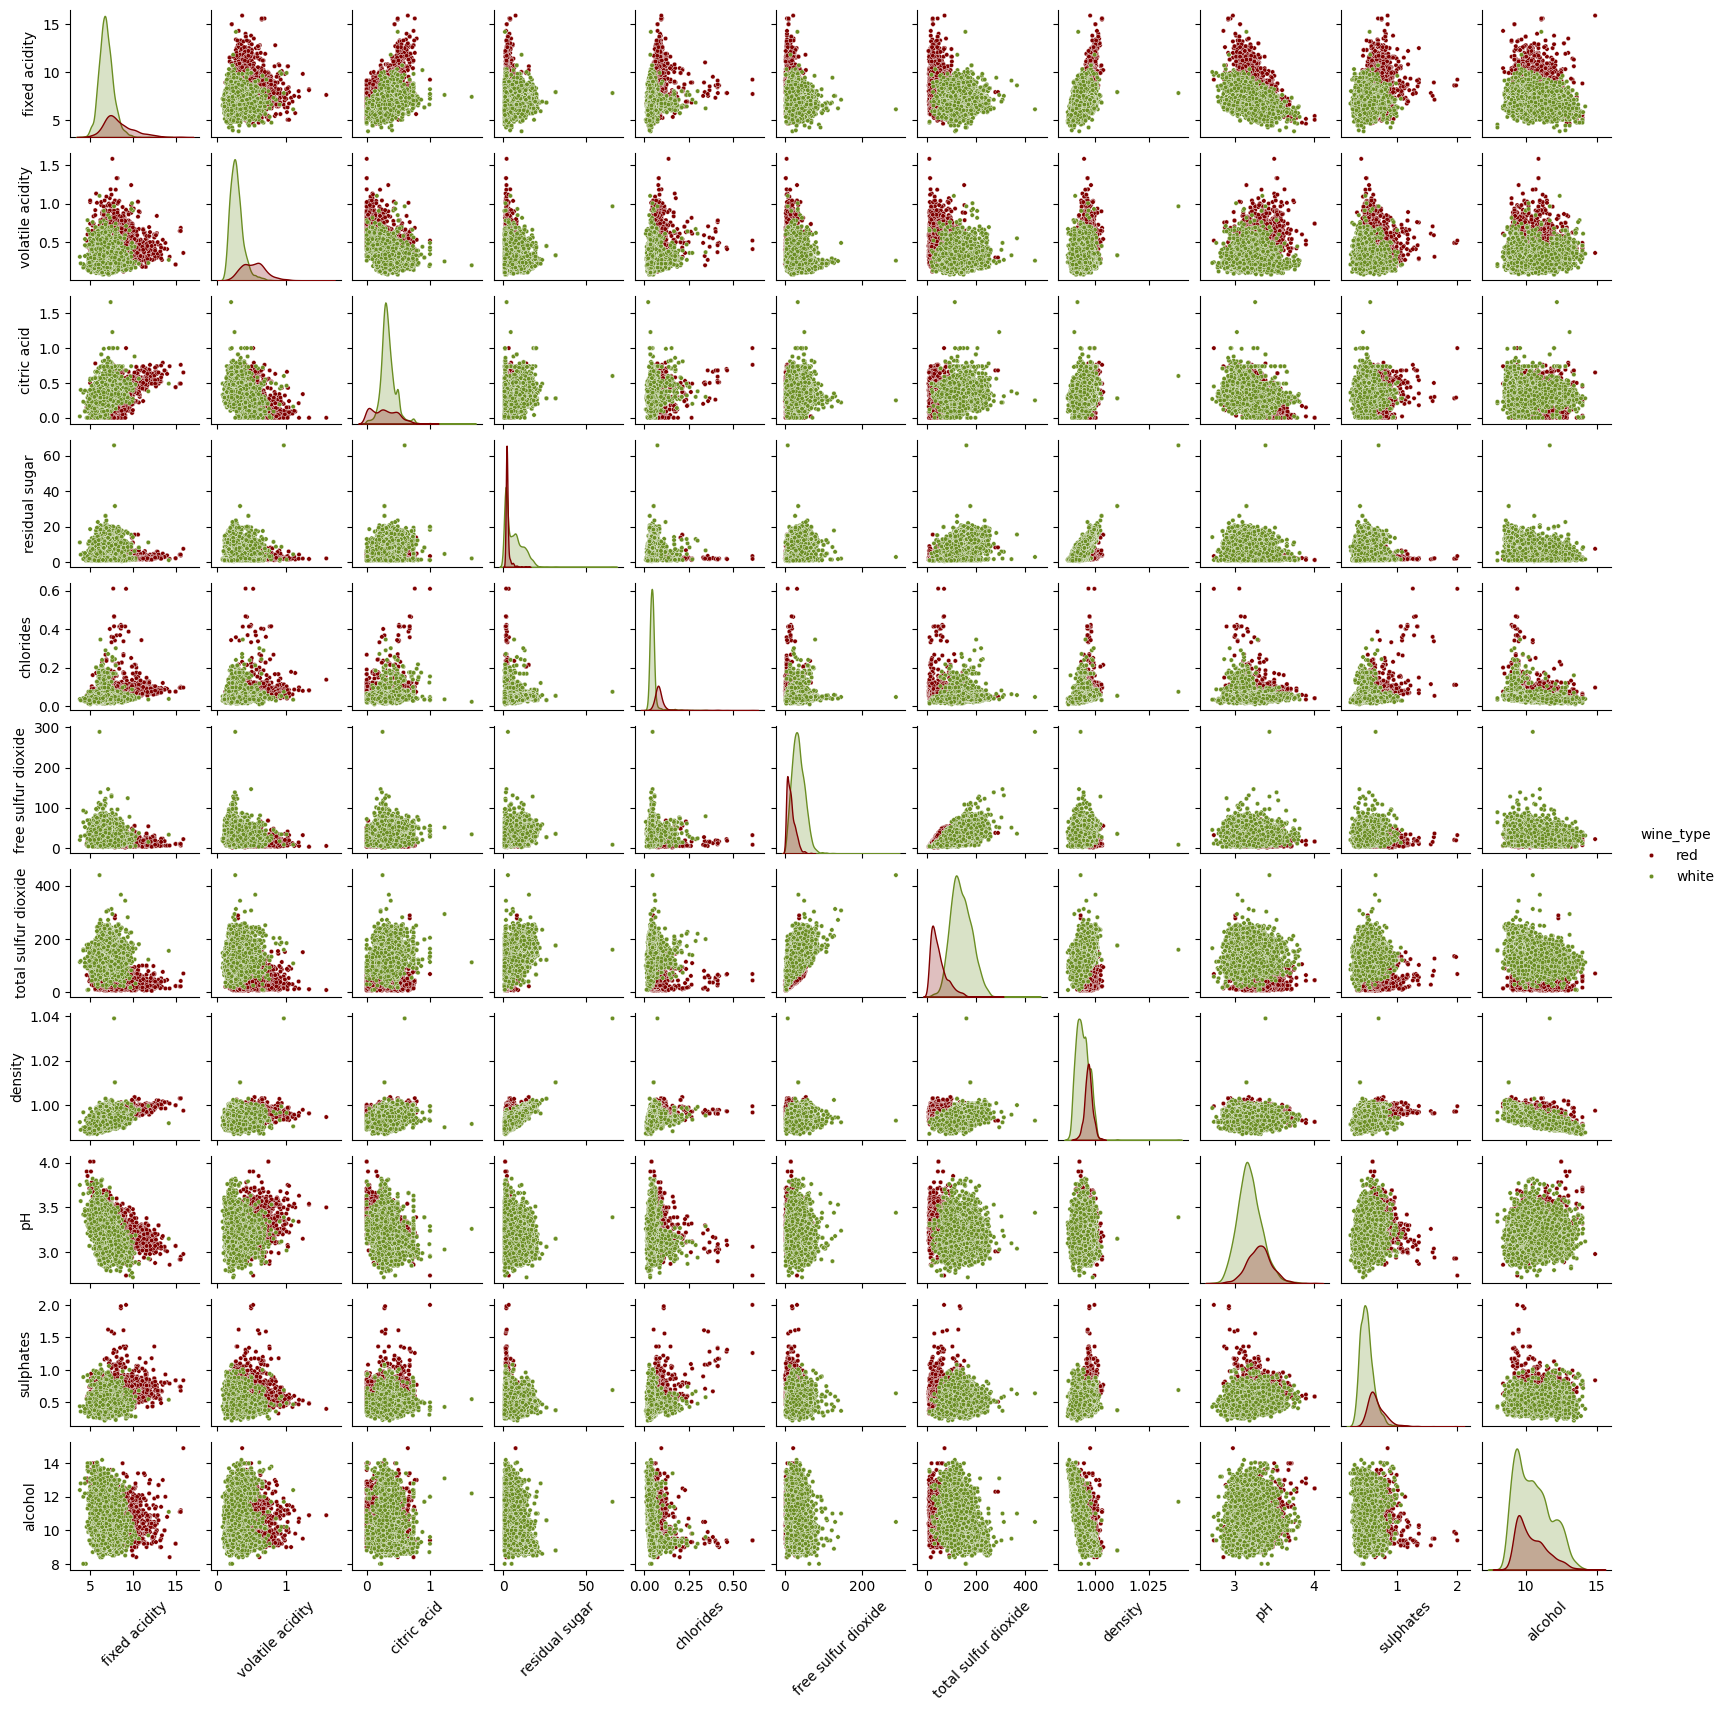

In [4]:
plt.figure(figsize=(10,10))
g = sns.pairplot(wine.drop(columns=["quality"]), 
             hue='wine_type', 
             height=1.5,
             palette={"red": "#800000", "white": "#6B8E23"},
             plot_kws={'s': 10})

for ax in g.axes[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), rotation=45)

plt.show()

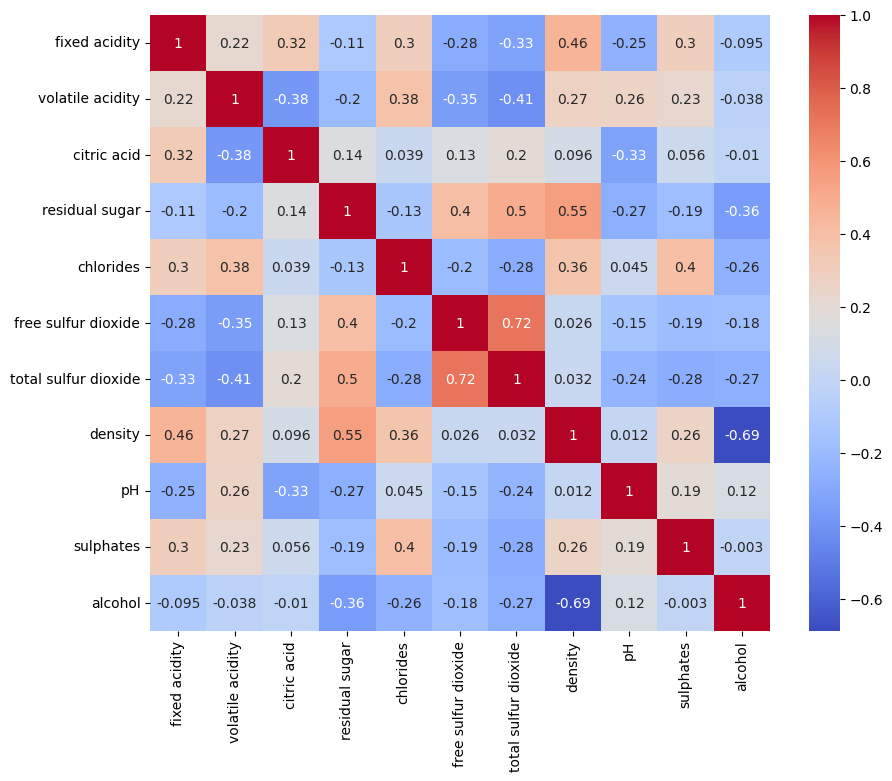

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(wine.drop(columns=['quality', 'wine_type']).corr(), annot=True, cmap="coolwarm")
plt.show()

There are features that are moderately correlated with each other. However, none was removed using the criteria |r| > 0.90. I believe that there are only a few features for this dataset, and removing one feature that is not highly correlated may result in loss of relevant information that will affect the predictive power of the machine learning models.

## Encode the Wine Color to Numeric Data
I encoded the categorical variable <code>wine_type</code> to numeric for convenience during model training, validation, and testing.

In [6]:
# Convert wine_type to numeric (0 - red, 1 - white)
encoder = LabelEncoder()
wine['wine_type'] = encoder.fit_transform(wine['wine_type'])
display(wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


## Train-test Split
I split the dataset to training set, validation set, and test set with ratio 70:15:15. This ensures that the models I developed will be valid for prediction of quality and wine color. I applied two splits, each for quality prediction (regression) and wine color prediction (classification), respectively.

In [7]:
# Train-test Split for Linear Regression (Quality Prediction)
X1 = wine.drop(columns=['quality']).to_numpy()
y1 = wine['quality'].to_numpy()

X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1, y1, test_size=0.3, random_state=0)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=0)

print(f'Linear Regression - Wine Quality Prediction')
print(X1_train.shape)
print(X1_val.shape)
print(X1_test.shape)

# Train-test Split for Logistic Regression (Color Prediction)
X2 = wine.drop(columns=['wine_type']).to_numpy()
y2 = wine['wine_type'].to_numpy()

X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2, y2, test_size=0.3, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=42)

print(f'Logistic Regression - Wine Color Prediction')
print(X2_train.shape)
print(X2_val.shape)
print(X2_test.shape)


Linear Regression - Wine Quality Prediction
(4547, 12)
(975, 12)
(975, 12)
Logistic Regression - Wine Color Prediction
(4547, 12)
(975, 12)
(975, 12)


## Ridge Regression Model (Prediction of Wine Quality)

### Training and Validation

I selected the L2 regularization parameter <code>alpha</code> as the hyperparameter to be tuned during training. By testing different values of <code>alpha</code>, we can find the model with the best performance ($R^2$) on validation set (which is unseen during training).

The values tested in this section are:
1. 0 (No penalty)
2. 0.1
3. 0.3
4. 1
5. 3
6. 10
7. 30
8. 100


In [8]:
# Initialize best metric and hyperparameter
max1_R2 = 0
best_alpha_1 = 0
best_mdl_1 = None

# Search for the best hyperparameter alpha
for alpha in np.array([0, 0.1, 0.3, 1, 3, 10, 30, 100]):
    mdl_1 = make_pipeline(StandardScaler(), Ridge(alpha=alpha)).fit(X1_train, y1_train)
    print(f"Alpha: {alpha}")

    train1_R2 = mdl_1.score(X1_train, y1_train)
    val1_R2 = mdl_1.score(X1_val, y1_val)

    print(f"\tCoefficients: {mdl_1[1].coef_}")
    print(f"\tIntercept: {mdl_1[1].intercept_}")
    print(f"\tTraining accuracy (R²): {train1_R2}")
    print(f"\tValidation accuracy (R²): {val1_R2}")

    if val1_R2 > max1_R2:
        max1_R2 = val1_R2
        best_alpha_1 = alpha
        best_mdl_1 = mdl_1

Alpha: 0.0
	Coefficients: [ 0.12294803 -0.23662479 -0.00424946  0.30737722 -0.03713686  0.07774347
 -0.07997089 -0.33740434  0.08939497  0.11008507  0.24599188 -0.15902593]
	Intercept: 5.819881240378829
	Training accuracy (R²): 0.2981526509801511
	Validation accuracy (R²): 0.2976750980021119
Alpha: 0.1
	Coefficients: [ 0.12284019 -0.23661821 -0.00424848  0.30719858 -0.03714599  0.07775232
 -0.07999201 -0.33711972  0.08933232  0.11006747  0.24610846 -0.15892022]
	Intercept: 5.819881240378829
	Training accuracy (R²): 0.298152646372737
	Validation accuracy (R²): 0.2976798789461257
Alpha: 0.3
	Coefficients: [ 0.12262516 -0.23660502 -0.00424649  0.30684235 -0.03716419  0.07776994
 -0.08003411 -0.33655224  0.08920739  0.11003238  0.24634084 -0.15870941]
	Intercept: 5.8198812403788285
	Training accuracy (R²): 0.29815260967407164
	Validation accuracy (R²): 0.2976893509192816
Alpha: 1.0
	Coefficients: [ 0.12187945 -0.23655852 -0.00423932  0.30560656 -0.03722747  0.07783076
 -0.08017992 -0.33458

### Testing the Best Ridge Regression Model

In [9]:
print(f"Best alpha: {best_alpha_1}")
print(f"Coefficients: {best_mdl_1[1].coef_}")
print(f"Intercept: {best_mdl_1[1].intercept_}")

test1_R2 = best_mdl_1.score(X1_test, y1_test)
print(f"Testing accuracy (R²) of Best Ridge Regression Model: {test1_R2}")

y1_train_pred = best_mdl_1.predict(X1_train)
y1_val_pred = best_mdl_1.predict(X1_val)
y1_test_pred = best_mdl_1.predict(X1_test)

test1_MSE = mean_squared_error(y1_test, y1_test_pred)
y1_test_var = np.var(y1_test)
test1_NMSE = test1_MSE / y1_test_var

print(f'MSE: {test1_MSE}')
print(f'NMSE: {test1_NMSE}')  # Better measure than MSE for comparability, normalized by variance of y

Best alpha: 30.0
Coefficients: [ 0.09817129 -0.23431704 -0.00371277  0.26588491 -0.03938479  0.07948097
 -0.08461542 -0.27231544  0.07504335  0.10599391  0.27182762 -0.13422732]
Intercept: 5.819881240378725
Testing accuracy (R²) of Best Ridge Regression Model: 0.28568885302472824
MSE: 0.5554994439121601
NMSE: 0.7143111469752719


From the results of validation, I found that the best model has <code>alpha</code> = 30, with $R^2$ value of 0.286 and NMSE of 0.714 on test dataset. These low scores were quite expected since we are only using a simple machine learning model for regression. This linear regression model is likely incapable of capturing complex patterns in the data. Furthermore, the wine quality variable is discrete, which may limit the predicting power of the regression model. 

It is possible that other more complex models perform better on predicting wine quality from the set of features available in the dataset.

### Plot of Actual vs. Predicted Wine Quality

I created a plot to visualize the relationship of the actual wine quality and the model's predicted wine quality. The plot shows weak correlation as shown by the points not lying as close to the 45-degree line. This result is supported by the $R^2$ value shown above. This suggests that the selected model may not be the most appropriate regression model for this dataset.

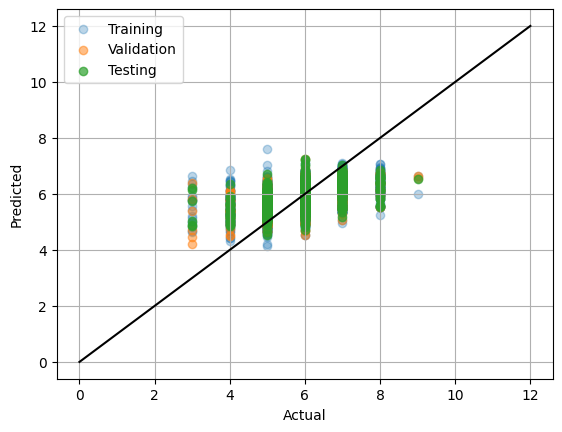

In [10]:
plt.plot(np.array([0, 12]), np.array([0, 12]), color='k', label='_nolegend_')   # 45-deg line

plt.scatter(y1_train, y1_train_pred, alpha=0.3, label="Training")
plt.scatter(y1_val, y1_val_pred, alpha=0.5, label="Validation")
plt.scatter(y1_test, y1_test_pred, alpha=0.7, label="Testing")

plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.legend()
plt.grid()
plt.show()

### (Experiment) Rounding Off Predicted Wine Quality

In [11]:
from sklearn.metrics import r2_score, accuracy_score

y1_test_pred_round = np.round(y1_test_pred)
test1_R2_round = r2_score(y1_test, y1_test_pred_round)
print(f'R² Score for Rounded Predicted Wine Quality: {test1_R2_round:.3f}')

R² Score for Rounded Predicted Wine Quality: 0.164


The $R^2$ score decreased after rounding off predicted wine quality values. We can try using accuracy instead as metric.

In [12]:
test1_acc_round = accuracy_score(y1_test, y1_test_pred_round)
print(f'Accuracy Score for Rounded Predicted Wine Quality: {test1_acc_round:.3f}')

Accuracy Score for Rounded Predicted Wine Quality: 0.510


The model correctly predicted more than half of wine quality values, which is better than random guessing considering that this is similar to a multi-class classification problem. Nevertheless, other models may likely perform better than this ridge regression model.

## Logistic Regression Model (Prediction of Wine Color)

### Training and Validation

For training and validation, I selected <code>penalty</code> as the hyperparameter to be tuned. The penalty ensures that the model to be developed will not overfit on the training set, making its predictive power on unseen data to be close with the training data.

Four penalties were tested during validation:
1. None
2. L2 (Ridge)
3. L1 (Lasso)
4. Elastic Net (Combination of L1 and L2)

In [13]:
# Initialize best metric and hyperparameter
max2_acc = 0
best_penalty = None
best_mdl_2 = None
penalty_list = [None, 'l2', 'l1', 'elasticnet']

# Search for the best hyperparameter
for penalty in penalty_list:
    if penalty in ['l2', None]:    # newton-cg solver only works for l2 and None
        model = LogisticRegression(solver='newton-cg', random_state=0, penalty=penalty, max_iter=500)
    elif penalty == 'elasticnet':  # saga solver works for elasticnet, but need to specify l1_ratio
        model = LogisticRegression(solver='saga', random_state=0, penalty=penalty, l1_ratio=0.2, max_iter=500)
    else:                          # saga solver also works for l1
        model = LogisticRegression(solver='saga', random_state=0, penalty=penalty, max_iter=500)

    mdl_2 = make_pipeline(StandardScaler(), model).fit(X2_train, y2_train)
    print(f"Penalty: {penalty}")

    train2_acc = mdl_2.score(X2_train, y2_train)
    val2_acc = mdl_2.score(X2_val, y2_val)

    print(f"\tTraining accuracy: {train2_acc}")
    print(f"\tValidation accuracy: {val2_acc}")

    if val2_acc > max2_acc:
        max2_acc = val2_acc
        best_penalty = penalty
        best_mdl_2 = mdl_2

print(f"Best penalty: {best_penalty}")
print(f'Accuracy: {best_mdl_2.score(X2_val, y2_val)}')

Penalty: None
	Training accuracy: 0.9947217945898394
	Validation accuracy: 0.9866666666666667
Penalty: l2
	Training accuracy: 0.9949417198152628
	Validation accuracy: 0.9846153846153847
Penalty: l1
	Training accuracy: 0.9947217945898394
	Validation accuracy: 0.9866666666666667
Penalty: elasticnet
	Training accuracy: 0.9949417198152628
	Validation accuracy: 0.9846153846153847
Best penalty: None
Accuracy: 0.9866666666666667


From the results above, using no penalties resulted in the best classifier performance on validations set. Thus, the model which applied no penalties to the weights were selected and evaluated on the test set.

### Testing the Best Logistic Regression Model

The intercept and coefficients of the best model is shown below.

In [14]:
y2_pred = best_mdl_2.predict(X2_test)

extracted_model = best_mdl_2.named_steps['logisticregression']
print(f'Coefficients: : {extracted_model.intercept_, extracted_model.coef_}')

Coefficients: : (array([4.97879454]), array([[-0.08184781, -1.60358131,  0.39292309,  5.32171451, -0.76029406,
        -1.31403527,  3.23473788, -4.91575594,  0.153257  , -0.60915355,
        -1.71663962, -0.30321189]]))


Using confusion matrices, accuracy score, and ROC-AUC score can be useful to evaluate the logistic regression classifier model. Accuracy score indicates the percentage of correct predictions made by the model. Confusion matrices show the number of correct predictions on the negative (0 - red) and positive (1 - white) class, as well as the false positives and false negatives. The ROC-AUC score describes the power of the model to distinguish properly between negative and positive classes (0.50 - random guessing, 1.00 perfect classifier).

Test Accuracy: 0.9938461538461538


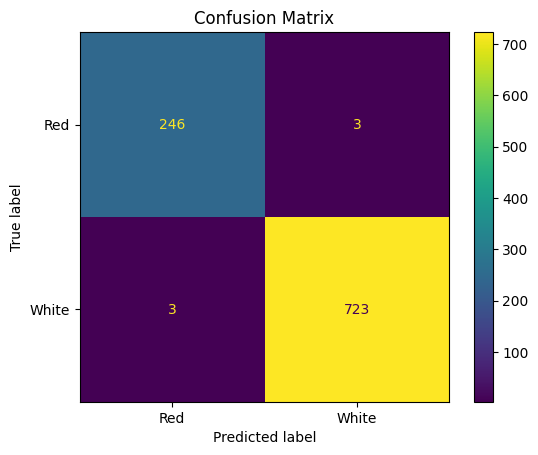

In [15]:
# Evaluation using accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f'Test Accuracy: {best_mdl_2.score(X2_test, y2_test)}')

cfm = confusion_matrix(y2_test, y2_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["Red", "White"])
cm_display.plot()

plt.title('Confusion Matrix')
plt.show()

The results show very good model performance with accuracy of 99.4%, with false positives and false negatives of 3 and 3, respectively, out of 975 test examples.

AUC:  0.9955137353823006


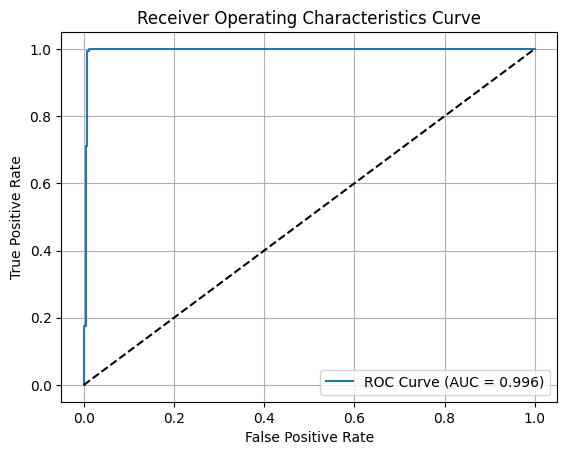

In [16]:
y2_test_proba = best_mdl_2.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(y2_test, y2_test_proba[:,1])
AUC = roc_auc_score(y2_test, y2_test_proba[:,1])
print(f"AUC: ", AUC)

plt.plot(fpr, tpr, '-', label=f'ROC Curve (AUC = {AUC:.3f})')
plt.plot(np.array([0, 1]), np.array([0, 1]), 'k--')
plt.title('Receiver Operating Characteristics Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()

plt.show()

A very high AUC score, as well as the shape of the ROC curve above the 45-deg line shows that the model performs very well on the test dataset. This is supported by the previous metrics shown before (accuracy and confusion matrix).

##  (Experiment) Try PCA for logistic curve visualization

In [17]:
# Get the first PC and use it as the feature for logistic regression
# This allows us to plot a y vs. x logistic curve

from sklearn.decomposition import PCA

PC_pipeline = make_pipeline(StandardScaler(), PCA(n_components=1))
X3 = PC_pipeline.fit_transform(X2)
y3 = y2
print("First Principal Component:\n", X3)

X3_train, X3_temp, y3_train, y3_temp = train_test_split(X3, y3, test_size=0.3, random_state=42)
X3_val, X3_test, y3_val, y3_test = train_test_split(X3_temp, y3_temp, test_size=0.5, random_state=42)

# Try searching for best penalty
max3_acc = 0
best_penalty_3 = None
best_mdl_3 = None

# Search for the best hyperparameter
for penalty in penalty_list:
    if penalty in ['l2', None]: 
        model = LogisticRegression(solver='newton-cg', random_state=0, penalty=penalty, max_iter=500)
    elif penalty == 'elasticnet':
        model = LogisticRegression(solver='saga', random_state=0, penalty=penalty, l1_ratio=0.2, max_iter=500)
    else:
        model = LogisticRegression(solver='saga', random_state=0, penalty=penalty, max_iter=500)

    mdl_3 = make_pipeline(StandardScaler(), model).fit(X3_train, y3_train)
    print(f"Penalty: {penalty}")

    train3_acc = mdl_3.score(X3_train, y3_train)
    val3_acc = mdl_3.score(X3_val, y3_val)

    print(f"\tTraining accuracy: {train3_acc}")
    print(f"\tValidation accuracy: {val3_acc}")

    if val3_acc > max3_acc:
        max3_acc = val3_acc
        best_penalty_3 = penalty
        best_mdl_3 = mdl_3

print(f"Best penalty: {best_penalty_3}")
print(f'Accuracy: {best_mdl_3.score(X3_val, y3_val)}')

First Principal Component:
 [[-3.34843817]
 [-3.22859545]
 [-3.23746833]
 ...
 [ 0.62692235]
 [ 0.49193416]
 [ 0.76155534]]
Penalty: None
	Training accuracy: 0.9824059819661315
	Validation accuracy: 0.9794871794871794
Penalty: l2
	Training accuracy: 0.9824059819661315
	Validation accuracy: 0.9794871794871794
Penalty: l1
	Training accuracy: 0.9824059819661315
	Validation accuracy: 0.9794871794871794
Penalty: elasticnet
	Training accuracy: 0.9824059819661315
	Validation accuracy: 0.9794871794871794
Best penalty: None
Accuracy: 0.9794871794871794


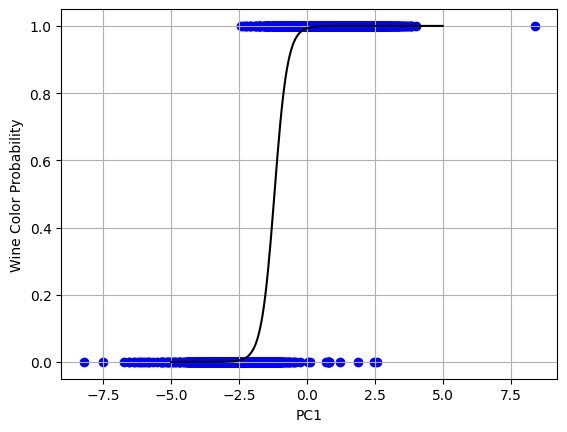

In [18]:
plt.scatter(X3, y3, color='b')

X3_curve = np.linspace(-5, 5, 200).reshape(-1,1)
y3_curve = best_mdl_3.predict_proba(X3_curve)

plt.plot(X3_curve, y3_curve[:,1], color='k')
plt.grid()
plt.xlabel("PC1")
plt.ylabel("Wine Color Probability")

plt.show()

Test Accuracy: 0.9753846153846154
Coefficients: : (array([5.05106101]), array([[7.18551448]]))


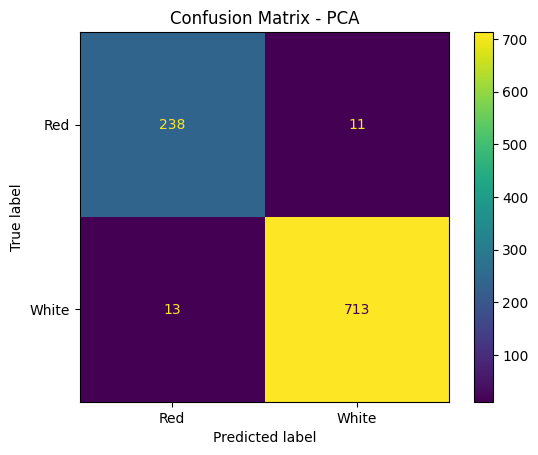

In [19]:
y3_pred = best_mdl_3.predict(X3_test)

print(f'Test Accuracy: {best_mdl_3.score(X3_test, y3_test)}')
extracted_model_3 = best_mdl_3.named_steps['logisticregression']
print(f'Coefficients: : {extracted_model_3.intercept_, extracted_model_3.coef_}')

cfm_3 = confusion_matrix(y3_test, y3_pred)

cm_display_3 = ConfusionMatrixDisplay(confusion_matrix=cfm_3, display_labels=["Red", "White"])
cm_display_3.plot()

plt.title('Confusion Matrix - PCA')
plt.show()